# Pairs Trading Backtester

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
from statsmodels.tsa.stattools import coint

In [2]:
class PairsTrading: 
    """
    Class to backtest pairs trading strategies between two assets
    INPUTS
    df : pandas dataframe containing a timeseries of the close prices of assets.
    tickers : list containing the tickers (str) of the two assets involved in the trading strategy. 
    N_means : list containing the lenght of the moving averages (int) for the z-score function. 
    
    """
    
    def __init__(self, df, tickers, N_means):
        self.df = df
        self.tickers = tickers
        self.N_means = N_means
    
    def z_score(self):
        """
        Function that calculates the z-score for the pairs trading strategy. 
        Takes df, tickers and N_means and outputs a pandas dataframe. 
        """
        ratio = self.df[self.tickers[0]] - self.df[self.tickers[1]]
        MA_short = ratio.rolling(self.N_means[0],center=False).mean().shift(1)
        MA_long = ratio.rolling(self.N_means[1],center=False).mean().shift(1)
        MSTD_long = ratio.rolling(self.N_means[1],center=False).std().shift(1)
        z = (MA_short - MA_long) / MSTD_long
        return z.dropna()
    
    def backtest(self):
        """
        Function to backtest the trading strategy. Given short sell is not available the trading algho 
        buy the first asset (in the tickers list) when Z < -1 and sell it when Z > 1.
        Takes df, tickers, calls for the z_score function and outputs a pandas dataframe with the
        operations log of the strategy. 
        """
        Z = self.z_score()
        ops_log = {'State':[],'Money':[]}
        Q_state = 0
        
        for i in range(1,len(Z)):
            if Z.iloc[i] < -1 and Z.iloc[i-1] >= -1 and Q_state == 0:
                Q_state = 1
                ops_log['State'].append('Buy')
                ops_log['Money'].append(-self.df[self.tickers[0]].loc[Z.index].iloc[i])

            elif Z.iloc[i] > 1 and Z.iloc[i-1] <= 1 and Q_state == 1:
                Q_state = 0
                ops_log['State'].append('Sell')
                ops_log['Money'].append(self.df[self.tickers[0]].loc[Z.index].iloc[i])

            else:
                ops_log['State'].append('Hold')
                ops_log['Money'].append(0)

        ops_log = pd.DataFrame(ops_log,index=Z.index[1:])
        ops_log['Trade profit'] = 0
        li = [ops_log['Money'][ops_log['State'] == 'Buy'].to_numpy(), ops_log['Money'][ops_log['State'] == 'Sell'].to_numpy()]
        li = pd.DataFrame(li).dropna(axis = 1).T
        ops_log.loc[ops_log['State'] == 'Sell', 'Trade profit'] = np.sum(li, axis = 1).values
        ops_log['Accum profit'] = ops_log['Trade profit'].cumsum()
        
        self.ops_log = ops_log
    
    def plot(self):
        """
        Function that plots the accumulated profit of the trading strategy and the price of the 
        first asset. Also calculates total return, CAGR and succes rate for the strategy. 
        Takes the operational logs dataframe from the backtest function and outputs a 
        matplotlib plot and prints text. 
        """
        fig, ax = plt.subplots(1, 1, figsize = (12,7))
        ax2 = ax.twinx()

        p1 = ax.plot(self.df[self.tickers[0]].loc[self.ops_log.index], label = self.tickers[0]+' Price')
        p2 = ax2.plot(self.ops_log['Accum profit'], label = 'Accum Gains', c='orange')
        p3 = ax.plot(abs(self.ops_log['Money'][self.ops_log['State'] == 'Buy']),color='g', linestyle='None', marker='^',label = 'Buy')
        p4 = ax.plot(abs(self.ops_log['Money'][self.ops_log['State'] == 'Sell']),color='r', linestyle='None', marker='^', label = 'Sell')
        p5 = ax2.plot(self.ops_log.index[-1],self.df[self.tickers[0]].loc[self.ops_log.index[-1]] - self.df[self.tickers[0]].loc[self.ops_log.index[0]],c='m',label = 'Buy n Hold profit', linestyle='None', marker='*', markersize=10)

        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax2.set_ylabel('Profit')
        ax.set_title('Pairs Trading Strategy Backtest - '+self.tickers[0]+'/'+self.tickers[1]+' - Timeframe: '+self.ops_log.index[0].strftime('%Y/%m')+' To '+self.ops_log.index[-1].strftime('%Y/%m'))
        ax.legend(p1+p2+p3+p4+p5,[l.get_label() for l in p1+p2+p3+p4+p5],loc=0)
        plt.show()

        total_return = self.ops_log['Accum profit'].iloc[-1] / abs(self.ops_log.loc[self.ops_log['State'] == 'Buy', 'Money'][0])
        y = (self.ops_log.index[-1] - self.ops_log.loc[self.ops_log['State'] == 'Buy', 'Money'].index[0]).days / 365
        CAGR = (1 + total_return)**(1/y) - 1
        succes_rate = sum(self.ops_log['Trade profit'] > 0)/len(self.ops_log[self.ops_log['Trade profit'] != 0])

        print('Total Return: '+str(round(total_return*100,2))+'%'+' | CAGR: '+str(round(CAGR*100,2))+'%'+
             ' | Success of trades: '+str(round(succes_rate*100,2))+'%'
              +' | Total profit: '+str(round(self.ops_log['Accum profit'].iloc[-1],2))+' per share')

def find_cointegrated_pairs(data,target):
    dic={i:[] for i in target}
    keys = data.columns.tolist()
    for S1 in target:
        for S2 in keys:
            if S1 == S2:
                pass
            else:
                pvalue = coint(data[S1], data[S2])[1]
                if pvalue < 0.05:
                    dic[S1].append(S2)
                    
    return {i:dic[i] for i in list(dic.keys()) if dic[i]!=[]}

In [4]:
data = yf.download('KO PEP',start='2010-1-1')['Adj Close'].dropna()

[*********************100%***********************]  2 of 2 completed


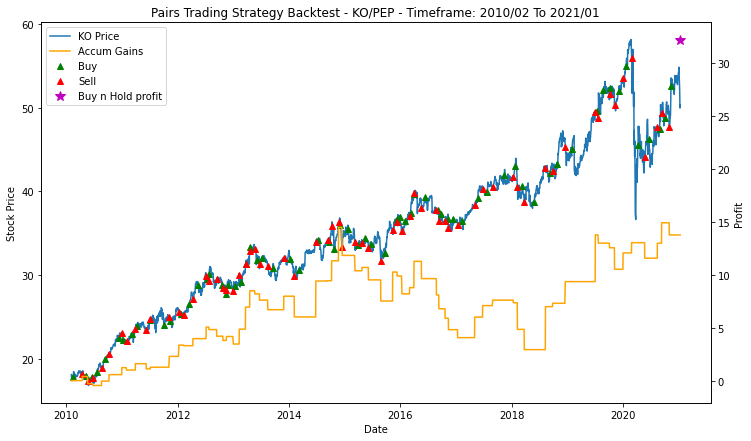

Total Return: 77.32% | CAGR: 5.39% | Success of trades: 50.75% | Total profit: 13.77 per share


In [5]:
obj = PairsTrading(data, ['KO','PEP'], [1,20])
obj.backtest()
obj.plot()